# Modeling
- Computing these models through Google Cloud Platform's Compute Engine **with GPUs** is highly recommended for efficiency purposes.
- A simple model (T1 Model) training on 250 3D-images, validating on 84 3D-images, with two Conv3D layers and one Dense layer, and 3 epochs took about 40 hours to run on my personal laptop.
- Introducing a second MRI type to the model (T1 & T2 Model) training on 501 3D-images, validating on 167 3D-images with two Conv3D layers and one Dense layer, and 3 epochs took about 6.5 hours using GCP's VM instance with 4CPUs and 256GB of RAM.

## Contents
- [Imports](#Imports)
- Models
    - [Model w/ T1 MRI](#T1-MRI)
    - [Model w/ T1, T2 MRI](#T1-&-T2-MRI)
    - [Model w/ T1, T1ce, T2, FLAIR MRI Types](#T1,-T1ce,-T2,-FLAIR-MRI-Types)

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras import utils
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, Conv3D, MaxPooling3D

## T1 MRI

In [2]:
# Bringing in only arrays of HGG T1 MRI images

t1_hgg = []
counter = 0

for file in os.listdir('./data/bet_processed/'):
    counter += 1
    if counter%100 == 0 or counter == len(os.listdir('./data/bet_processed/'))-1:
        print(f"{counter} out of {len(os.listdir('./data/bet_processed/'))-1}")
              
    if file.endswith('t1_n4_bet.nii.gz'):
        file_path = './data/bet_processed/' + file
        img = nib.load(file_path)
        array_flat = img.get_data() / 255
        t1_hgg.append(array_flat)

100 out of 1032
200 out of 1032
300 out of 1032
400 out of 1032
500 out of 1032
600 out of 1032
700 out of 1032
800 out of 1032
900 out of 1032
1000 out of 1032
1032 out of 1032


In [3]:
# Bringing in only arrays of LGG T1 MRI Images

t1_lgg = []
counter = 0

for file in os.listdir('./data/lgg_bet_processed/'):
    counter += 1
    if counter%100 == 0 or counter == len(os.listdir('./data/lgg_bet_processed/'))-1:
        print(f"{counter} out of {len(os.listdir('./data/lgg_bet_processed/'))-1}")
              
    if file.endswith('t1_n4_bet.nii.gz'):
        file_path = './data/lgg_bet_processed/' + file
        img = nib.load(file_path)
        array_flat = img.get_data() / 255
        t1_lgg.append(array_flat)

100 out of 303
200 out of 303
300 out of 303
303 out of 303


In [4]:
# Setting X and y for neural network

t1_hgg_y = np.ones(shape=len(t1_hgg), dtype=int)
t1_lgg_y = np.zeros(shape=len(t1_lgg), dtype=int)

X = np.array(t1_hgg + t1_lgg)
y = np.array(list(t1_hgg_y) + list(t1_lgg_y))

In [5]:
# % of Data that's Target: 1 (HGG)
sum(y) / len(y)

0.7724550898203593

In [6]:
# Train-test splitting; unbalanced classes so stratify on y
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   stratify=y)

In [7]:
# Shape of training data
X_train.shape

(250, 240, 240, 155)

In [8]:
# Shape of testing data
X_test.shape

(84, 240, 240, 155)

In [9]:
# Input shape for Conv3D has to be 5D tesnor with
# shape (batch, dim1, dim2, dim3, channels)
X_train = X_train.reshape(X_train.shape[0], 240, 240, 155, 1) 
X_test = X_test.reshape(X_test.shape[0], 240, 240, 155, 1)

In [10]:
# Target array has to be categorical for Conv3D
y_train = utils.to_categorical(y_train) 
y_test = utils.to_categorical(y_test)

In [12]:
# REALLY BASIC 3D-CNN
# Hardware limitation; Google Compute Engine configurations didn't work
# Once GCE configs. figured out, can make more complex model

# 2 Conv3D Layers, 1 Dense Layer

cnn = Sequential()

cnn.add(Conv3D(
    filters=6,
    kernel_size=(3,3,3), # height/width of filter
    activation='relu',
    input_shape=(240, 240, 155, 1)))

cnn.add(MaxPooling3D(
    pool_size=(2,2,2)
))

cnn.add(Conv3D(
    filters= 16,
    kernel_size= (3,3,3),
    activation='relu'
))

cnn.add(MaxPooling3D(
    pool_size=(2,2,2)
))

cnn.add(Flatten())

cnn.add(Dense(
    units=128,
    activation='relu'
))

# Output Layer
cnn.add(Dense(
    units=2,
    activation='softmax'
))

cnn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
# Fitting model with only 3 epochs -- hardware limitation
history = cnn.fit(np.array(X_train), y_train,
                 batch_size=32,
                 validation_data=(np.array(X_test), y_test),
                 epochs=3,
                 verbose=1)

Train on 250 samples, validate on 84 samples
Epoch 1/3
250/250 [==============================] - 31594s 126s/sample - loss: 67.3403 - acc: 0.5280 - val_loss: 37.0916 - val_acc: 0.7738
Epoch 2/3
250/250 [==============================] - 32567s 130s/sample - loss: 7.3920 - acc: 0.7120 - val_loss: 2.3620 - val_acc: 0.7738
Epoch 3/3
250/250 [==============================] - 28437s 114s/sample - loss: 0.5137 - acc: 0.8120 - val_loss: 0.9381 - val_acc: 0.7738


In [18]:
# Saving the model that was fitted above
# cnn.save(filepath='./pickles/01_model.h5')

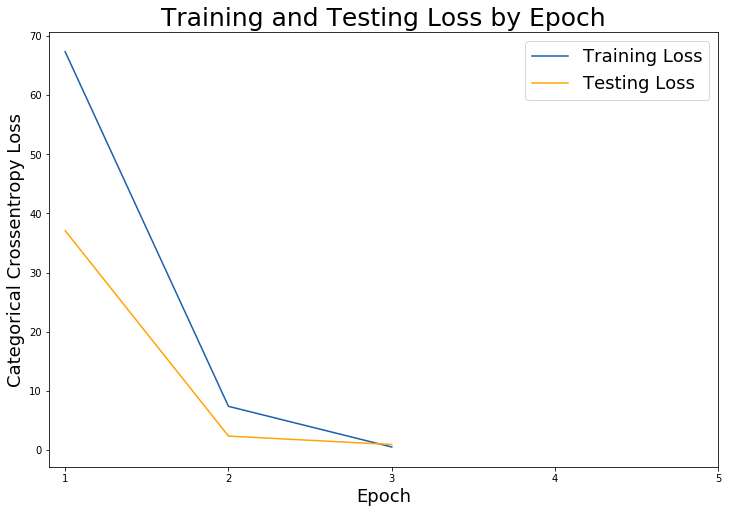

In [11]:
# Check out our train loss and test loss over epochs.
x_loss = [1, 2, 3]
train_loss = [67.3403, 7.3920, 0.5137]
test_loss = [37.0916, 2.3620, 0.9381]

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(x_loss, train_loss, label='Training Loss', color='#185fad')
plt.plot(x_loss, test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy Loss', fontsize = 18)
plt.xticks([1, 2, 3, 4, 5])
plt.legend(fontsize = 18);

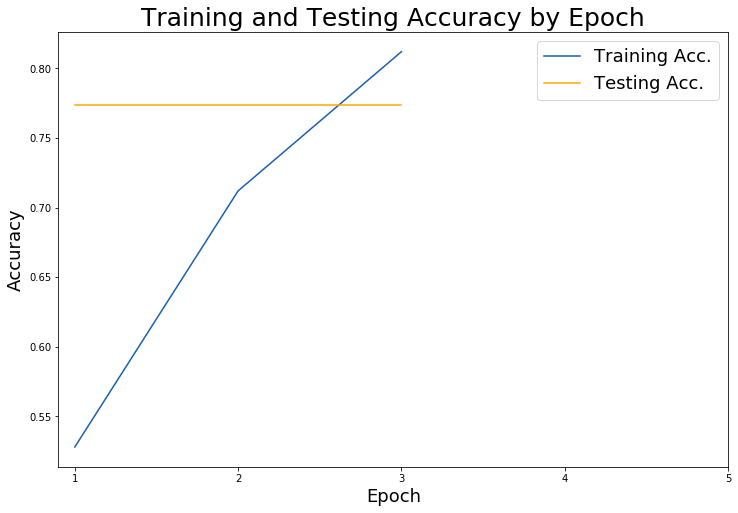

In [10]:
# Check out our train loss and test loss over epochs.
x_acc = [1, 2, 3]
train_acc = [0.5280, 0.7120, 0.8120]
test_acc = [0.7738, 0.7738, 0.7738]

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(x_acc, train_acc, label='Training Acc.', color='#185fad')
plt.plot(x_acc, test_acc, label='Testing Acc.', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([1, 2, 3, 4, 5])
plt.legend(fontsize = 18);

## T1 & T2 MRI
- Using GCP's Compute Engine with a VM instance of 4CPUs/256GB RAM.
- Attempted to use GPUs but had some conflicts with NVIDIA drivers and CUDA.
- Will expand neural network further once NVIDIA and CUDA configurations work.

In [6]:
# Bringing in only arrays of HGG T1 & T2 MRI images
t1_t2_hgg = []
counter = 0

for file in os.listdir('./bet_processed/'):
    counter += 1
    if counter%100 == 0 or counter == len(os.listdir('./bet_processed/'))-1:
        print(f"{counter} out of {len(os.listdir('./bet_processed/'))-1}")
              
    if file.endswith('t1_n4_bet.nii.gz') or file.endswith('t2_n4_bet.nii.gz'):
        file_path = './bet_processed/' + file
        img = nib.load(file_path)
        array_flat = img.get_data() / 255
        t1_t2_hgg.append(array_flat)

100 out of 1032
200 out of 1032
300 out of 1032
400 out of 1032
500 out of 1032
600 out of 1032
700 out of 1032
800 out of 1032
900 out of 1032
1000 out of 1032
1032 out of 1032


In [7]:
# Bringing in only arrays of LGG T1 & T2 MRI images
t1_t2_lgg = []
counter = 0

for file in os.listdir('./lgg_bet_processed/'):
    counter += 1
    if counter%100 == 0 or counter == len(os.listdir('./lgg_bet_processed/'))-1:
        print(f"{counter} out of {len(os.listdir('./lgg_bet_processed/'))-1}")
              
    if file.endswith('t1_n4_bet.nii.gz') or file.endswith('t2_n4_bet.nii.gz'):
        file_path = './lgg_bet_processed/' + file
        img = nib.load(file_path)
        array_flat = img.get_data() / 255
        t1_t2_lgg.append(array_flat)

100 out of 303
200 out of 303
300 out of 303
303 out of 303


In [8]:
# Setting X and y for neural network
t1_t2_hgg_y = np.ones(shape=len(t1_t2_hgg), dtype=int)
t1_t2_lgg_y = np.zeros(shape=len(t1_t2_lgg), dtype=int)

X = np.array(t1_t2_hgg + t1_t2_lgg)
y = np.array(list(t1_t2_hgg_y) + list(t1_t2_lgg_y))

In [9]:
# % of Data that's Target: 1 (HGG)
sum(y) / len(y)

0.7724550898203593

In [10]:
# Train test splitting; unbalanced classes so stratify on y
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   stratify=y)

In [11]:
# Shape of training data
X_train.shape

(501, 240, 240, 155)

In [12]:
# Shape of testing data
X_test.shape

(167, 240, 240, 155)

In [13]:
# Input shape for Conv3D has to be 5D tesnor with
# shape (batch, dim1, dim2, dim3, channels)
X_train = X_train.reshape(X_train.shape[0], 240, 240, 155, 1) 
X_test = X_test.reshape(X_test.shape[0], 240, 240, 155, 1)

In [14]:
# Target array has to be categorical for Conv3D
y_train = utils.to_categorical(y_train) 
y_test = utils.to_categorical(y_test)

In [15]:
# REALLY BASIC 3D-CNN
# Hardware limitation; Google Compute Engine configurations didn't work
# Once GCE configs. figured out, can make more complex model

# 2 Conv3D Layers, 1 Dense Layer

cnn = Sequential()

cnn.add(Conv3D(
    filters=6,
    kernel_size=(3,3,3), # height/width of filter
    activation='relu',
    input_shape=(240, 240, 155, 1)))

cnn.add(MaxPooling3D(
    pool_size=(2,2,2)
))

cnn.add(Conv3D(
    filters= 16,
    kernel_size= (3,3,3),
    activation='relu'
))

cnn.add(MaxPooling3D(
    pool_size=(2,2,2)
))

cnn.add(Flatten())

cnn.add(Dense(
    units=128,
    activation='relu'
))

# Output Layer
cnn.add(Dense(
    units=2,
    activation='softmax'
))

cnn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
# Fitting model with only 3 epochs, 4 workers -- hardware limitation
history = cnn.fit(np.array(X_train), y_train,
                 batch_size=32,
                 validation_data=(np.array(X_test), y_test),
                 epochs=3,
                 verbose=1,
                 workers = 4)

Train on 501 samples, validate on 167 samples
Epoch 1/3
501/501 [==============================] - 9171s 18s/sample - loss: 42.9480 - acc: 0.4750 - val_loss: 0.6871 - val_acc: 0.6228
Epoch 2/3
501/501 [==============================] - 9169s 18s/sample - loss: 1.0852 - acc: 0.7285 - val_loss: 0.6852 - val_acc: 0.7725
Epoch 3/3
501/501 [==============================] - 9046s 18s/sample - loss: 0.6819 - acc: 0.7725 - val_loss: 0.6788 - val_acc: 0.7725


In [17]:
# Saving the model that was fitted above
# cnn.save(filepath='./t1_t2_model.h5')

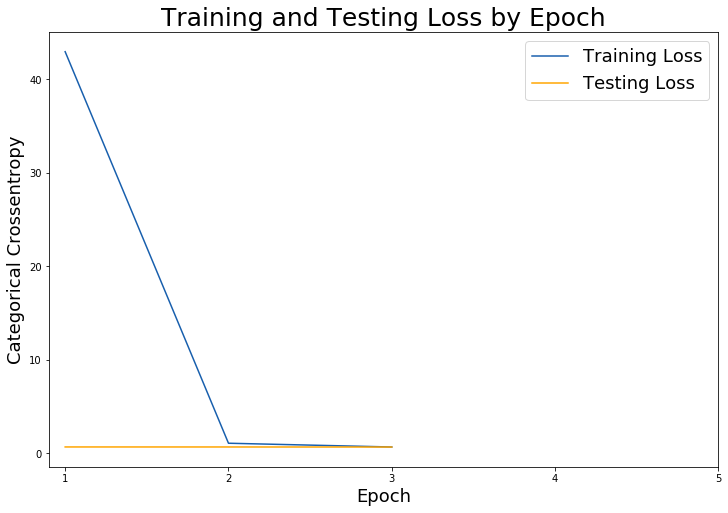

In [24]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy Loss', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4], [1, 2, 3, 4, 5])
plt.legend(fontsize = 18);

The graph above shows the training and testing loss at each epoch. After the first epoch, the loss scores are decreasing for both the training and testing data.

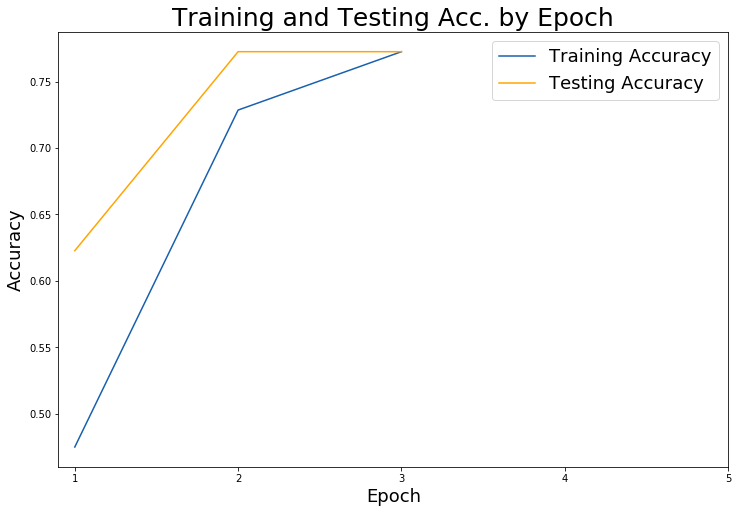

In [25]:
# Check out our train loss and test accuracy over epochs.
train_loss = history.history['acc']
test_loss = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing accuracy over epochs.
plt.plot(train_loss, label='Training Accuracy', color='#185fad')
plt.plot(test_loss, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Acc. by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4], [1, 2, 3, 4, 5])
plt.legend(fontsize = 18);

The graph above shows the training and testing accuracy at each epoch. After the first epoch, the accuracy scores are increasing for both the training and testing data.

In [ ]:
# # **Modeling on GPU code**
# # This code had trouble running due to Keras not detecting XLA_GPUs as GPUs.
# # Need to make more hardware configurations/installations before running on GPUs

# # Replicates `model` on 2 GPUs.
# # This assumes that your machine has 2 available GPUs.
# parallel_model = multi_gpu_model(cnn, gpus=2)
# parallel_model.compile(loss='categorical_crossentropy',
#                        optimizer='adam',
#                       metrics = ['accuracy'])


# # This `fit` call will be distributed on 2 GPUs.
# # Since the batch size is 32, each GPU will process 16 samples.
# history = parallel_model.fit(np.array(X_train), y_train,
#                              batch_size=32,
#                              validation_data=(np.array(X_test), y_test),
#                              epochs=3,
#                              verbose=1)

## T1, T1ce, T2, FLAIR MRI Types
- *Note*: This model was not performed due to hardware limitations, once GPU configurations are figured out on Google Compute Engine, this section will be run and complexity of neural network will be adjusted accordingly.
- If model with T1 & T2 MRIs proves to be better than a model with only T1 MRIs, this section will be attempted to see how well the accuracy is.
- If Model T1 & T2 is worse than T1 Model, will make a separate neural network for each MRI type instead.

In [ ]:
# Bringing in arrays of all HGG MRI images
hgg_img_data_train = []
counter = 0

for file in os.listdir('./data/bet_processed/'):
    if file.endswith('.nii.gz'):
        file_path = './data/bet_processed/' + file
        img = nib.load(file_path)
        array_flat = img.get_data() / 255
        hgg_img_data_train.append(array_flat)
        
        counter += 1
        if counter%100 == 0:
            print(f"{counter} out of {len(os.listdir('./data/bet_processed/'))-1}")

In [ ]:
# Bringing in arrays of all LGG MRI images
lgg_img_data_train = []
counter = 0

for file in os.listdir('./data/lgg_bet_processed/'):
    if file.endswith('.nii.gz'):
        file_path = './data/lgg_bet_processed/' + file
        img = nib.load(file_path)
        array_flat = img.get_data() / 255
        lgg_img_data_train.append(array_flat)
        
        counter += 1
        if counter%100 == 0:
            print(f"{counter} out of {len(os.listdir('./data/lgg_bet_processed/'))-1}")

In [ ]:
# Setting X and y for neural network

t1_hgg_y = np.ones(shape=len(t1_hgg), dtype=int)
t1_lgg_y = np.zeros(shape=len(t1_lgg), dtype=int)

X = np.array(t1_hgg + t1_lgg)
y = np.array(list(t1_hgg_y) + list(t1_lgg_y))

In [ ]:
# % of Data that's Target: 1 (HGG)
sum(y) / len(y)

In [ ]:
# Train-test splitting; unbalanced classes so stratify on y
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   stratify=y)

In [ ]:
# Shape of training data
X_train.shape

In [ ]:
# Shape of testing data
X_test.shape

In [ ]:
# Input shape for Conv3D has to be 5D tesnor with
# shape (batch, dim1, dim2, dim3, channels)
X_train = X_train.reshape(X_train.shape[0], 240, 240, 155, 1) 
X_test = X_test.reshape(X_test.shape[0], 240, 240, 155, 1)

In [ ]:
# Target array has to be categorical for Conv3D
y_train = utils.to_categorical(y_train) 
y_test = utils.to_categorical(y_test)

In [ ]:
# REALLY BASIC 3D-CNN
# Hardware limitation; Google Compute Engine configurations didn't work
# Once GCE configs. figured out, can make more complex model

# 2 Conv3D Layers, 1 Dense Layer

cnn = Sequential()

cnn.add(Conv3D(
    filters=6,
    kernel_size=(3,3,3), # height/width of filter
    activation='relu',
    input_shape=(240, 240, 155, 1)))

cnn.add(MaxPooling3D(
    pool_size=(2,2,2)
))

cnn.add(Conv3D(
    filters= 16,
    kernel_size= (3,3,3),
    activation='relu'
))

cnn.add(MaxPooling3D(
    pool_size=(2,2,2)
))

cnn.add(Flatten())

cnn.add(Dense(
    units=128,
    activation='relu'
))

# Output Layer
cnn.add(Dense(
    units=2,
    activation='softmax'
))

cnn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# Fitting model with only 3 epochs -- hardware limitation
history = cnn.fit(np.array(X_train), y_train,
                 batch_size=32,
                 validation_data=(np.array(X_test), y_test),
                 epochs=3,
                 verbose=1)

In [ ]:
# Saving the model that was fitted above
# cnn.save(filepath='./pickles/all_model.h5')